In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue2 as prologue

print('libraries imported')

libraries imported


To get the data for the first project, we are using one of the functions of *dlc_practical_prologe.py* that randomly generates one for us given a size parameter. It returns a tuple containing the: *training set, targets, classes* and *testing set, targets, classes*. 

In [2]:
sample_size = 1000
sets = prologue.generate_pair_sets(sample_size)

train_set = sets[0]
train_target = sets[1]
train_classes = sets[2]

test_set = sets[3]
test_target = sets[4]
test_classes = sets[5]

The inputs are grayscale MNIST images consisting of two channels ($2 \times 14 \times 14$) representing two different digits. As visualized below, target vector contains the index of the channels which have the highest digit between the two (channel $0$ or $1$). 

Therefore, our task is to maximize the prediction of this boolean value.

For the first training data point with two channels, target is 0


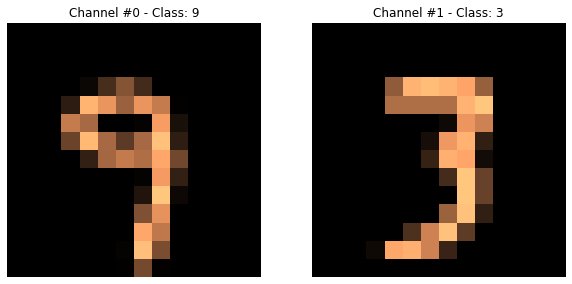

In [3]:
print('For the first training data point with two channels, target is {}'.format(train_target[0]))
fig1, axes = plt.subplots(1, 2, figsize = (10, 7))
ax = axes.ravel()

for i in range(len(ax)):
    ax[i].set_title('Channel #{} - Class: {}'.format(i, train_classes[0][i]))
    ax[i].imshow(train_set[0][i], cmap='copper')
    ax[i].axis('off')
plt.show()

Function to train the model by moving it through the given mini batch size and using Adam as an optimizer.

In [56]:
def train_model(n_epochs, eta, loss_criterion, optim, model, train_input, train_target, mini_batch_size):
    optimizer = optim
    for e in range(n_epochs):
        acc_loss = 0 ## set error as 0 each iteration
        ## Using mini-batches
        for b in range(0, train_input.size(0), mini_batch_size): 
            output = model(train_input.narrow(0, b, mini_batch_size))
            # print('Loss Shapes: Output: {}, Target: {}'.format(output.shape, train_target.narrow(0, b, mini_batch_size).shape))
            loss = loss_criterion(output, train_target.narrow(0, b, mini_batch_size))
            acc_loss = acc_loss + loss.item()

            optimizer.zero_grad()
            model.zero_grad() ## setting the gradients to zero before the loss calculation
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                for p in model.parameters():
                    p -= eta * p.grad
                    
    # print('Final Output: ', output, output.shape)
    # print(torch.argmax(output, dim=1))
    print('Model Training Finished - Final loss after {} epochs: {}'.format(n_epochs, acc_loss))

Round the final values outputted from the network into binary values and compare them with the target binary matrix in order to get the number of errors.

In [5]:
def compute_nb_errors(model, input, target):
    with torch.no_grad():
        rounded_to_binary = torch.round(input)
        errors = torch.where(rounded_to_binary != train_target)
    return len(errors[0]) / target.shape[0]

Attempt #1 - Binary Convolutional Network Classifier that takes the number of the hidden layers of the final fully connected layer as a parameter. 

As seen from the results below, it suffers from overfitting at the moment therefore it should be modified (dropout to be added next).

In [6]:
class BinaryCNN(nn.Module):
    def __init__(self, hidden_layer_n, dropout_rate): ## defining the layers
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.flatten0 = nn.Flatten(0)
        self.flatten1 = nn.Flatten(1)
        
        # Feature Extractors
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=1, stride=1)
        
        # Classifiers
        self.fc1 = nn.Linear(64, hidden_layer_n)
        self.fc2 = nn.Linear(hidden_layer_n, 1) ## output layers
        
    ## Generally, strides for convolution layers are 1 and for maxpools are 2
    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size = 2, stride = 2)
        # print('First Conv Layer Shape', x.shape)
        x = self.dropout(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size = 2, stride = 2)
        # print('Second Conv Layer Shape', x.shape)
        x = self.dropout(x)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size = 2, stride = 2)
        x = self.flatten1(x)
        # print('After Flattening', x.shape)
        x = self.dropout(x)
        x = self.fc1(x)
        # print('First Connected Layer', x.shape)
        # x = self.dropout(x)

        # x = torch.sigmoid(self.fc2(x))
        x = self.fc2(F.relu(x)) ## added a relu before the final fully connected layer
        x = self.flatten0(x)
        # print('Final Output Shape {} \n'.format(x.shape))
        return x

Benchmarking with different hyperparameters.

In [21]:
hidden_layers = [50, 200, 500, 1000]
binary_criterion = nn.BCEWithLogitsLoss()
eta = 0.001
mini_batch_size = 20
nb_epochs = 40
n_runs = 5


for i in range(n_runs):   
    model = BinaryCNN(hidden_layer_n = 200, dropout_rate = 0.15)
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001)
    train_model(nb_epochs, eta, binary_criterion, optimizer, model, train_set, train_target.to(torch.float32), mini_batch_size)
    
    train_output = torch.sigmoid(model(train_set))
    # print('test output', model(test_set))
    test_output = torch.sigmoid(model(test_set))
    
    error_train = compute_nb_errors(model, train_output, train_target.to(torch.float32))
    error_test = compute_nb_errors(model, test_output, test_target.to(torch.float32))
    
    print('Classification Error on the training set with {} hidden layers: {}%'.format(200, error_train * 100))
    print('Classification Error on the testing set with {} hidden layers: {}%'.format(200, error_test * 100))
    print('')

Model Training Finished - Final loss after 40 epochs: 6.014523114077747
Classification Error on the training set with 200 hidden layers: 6.7%
Classification Error on the testing set with 200 hidden layers: 48.4%

Model Training Finished - Final loss after 40 epochs: 7.016759840771556
Classification Error on the training set with 200 hidden layers: 4.2%
Classification Error on the testing set with 200 hidden layers: 51.6%

Model Training Finished - Final loss after 40 epochs: 4.68405288644135
Classification Error on the training set with 200 hidden layers: 3.6999999999999997%
Classification Error on the testing set with 200 hidden layers: 49.5%

Model Training Finished - Final loss after 40 epochs: 4.740005012834445
Classification Error on the training set with 200 hidden layers: 3.2%
Classification Error on the testing set with 200 hidden layers: 50.7%

Model Training Finished - Final loss after 40 epochs: 5.219558940734714
Classification Error on the training set with 200 hidden layer

Attempt #2 - Multi-Layer Perceptron with only linear hidden layers, constructed in order to compare the difference between this and the convolutional network, measuring the overfitting too. This network includes multiple dropout layers with respective rates of $0.4$ and a weight decay parameter on the Adam Optimizer, as measures to combat the above mentioned overfitting.

In [59]:
class MLP(nn.Module):
    def __init__(self, dropout_rate): ## defining the layers
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.flatten_dim_0 = nn.Flatten(0)
        self.flatten_dim_1 = nn.Flatten(1)

        # Fully Connected Layers        
        # self.fc1 = nn.Linear(2 * 14 * 14, 1028) ## (2x14x14) images
        # self.fc2 = nn.Linear(1028, 512)
        # self.fc3 = nn.Linear(512, 256)
        # self.fc4 = nn.Linear(256, 1) ## output layers
        
        self.fc1 = nn.Linear(2 * 14 * 14, 1028) ## (2x14x14) images
        self.fc2 = nn.Linear(1028, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1) ## output layers

        
    ## Generally, strides for convolution layers are 1 and for maxpools are 2
    def forward(self, x): 
        x = self.flatten_dim_1(x)
        # print('Flattened Input Shape: ', x.shape)
        x = F.relu(self.fc1(x))
        # print('First FC Layer Shape', x.shape)
        x = F.relu(self.dropout(self.fc2(x)))
        x = self.batchnorm1(x)
        # print('Second FC Layer Shape', x.shape)
        x = F.relu(self.dropout(self.fc3(x)))
        x = self.batchnorm2(x)
        # print('Third FC Layer Shape', x.shape)
        x = self.fc4(x)
        x = self.flatten_dim_0(x)
        # print('Final Output Shape {} \n'.format(x.shape))
        return x

For this network, the batch size was increased to 200 as it improved the accuracy overall.

In [58]:
binary_criterion = nn.BCEWithLogitsLoss()
eta = 1e-07
mini_batch_size = 200
nb_epochs = 50
n_runs = 5

# For Plotting Purposes
all_epochs = []
all_training_errors = []
all_testing_errors = []

for i in range(n_runs):
    # all_epochs.append(i)
    model = MLP(dropout_rate = 0.4)
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.1)
    train_model(nb_epochs, eta, binary_criterion, optimizer, model, train_set, train_target.to(torch.float32), mini_batch_size)
    
    train_output = torch.sigmoid(model(train_set))
    # print('test output', model(test_set))
    test_output = torch.sigmoid(model(test_set))
    
    error_train = compute_nb_errors(model, train_output, train_target.to(torch.float32))
    error_test = compute_nb_errors(model, test_output, test_target.to(torch.float32))
    
    # all_training_errors.append(error_train)
    # all_testing_errors.append(error_test)
        
    print('Classification Error on the training set: {}%'.format(error_train * 100))
    print('Classification Error on the testing set: {}%'.format(error_test * 100))
    print('')

Model Training Finished - Final loss after 50 epochs: 0.045052532106637955
Classification Error on the training set: 0.0%
Classification Error on the testing set: 48.0%

Model Training Finished - Final loss after 50 epochs: 0.05247680563479662
Classification Error on the training set: 0.0%
Classification Error on the testing set: 46.9%

Model Training Finished - Final loss after 50 epochs: 0.09045448340475559
Classification Error on the training set: 0.1%
Classification Error on the testing set: 47.4%

Model Training Finished - Final loss after 50 epochs: 0.9463182985782623
Classification Error on the training set: 3.1%
Classification Error on the testing set: 46.0%

Model Training Finished - Final loss after 50 epochs: 0.049420520663261414
Classification Error on the training set: 0.0%
Classification Error on the testing set: 48.6%



As we can view from the plot below, the overfitting on the testing set persists no matter the number of epochs.

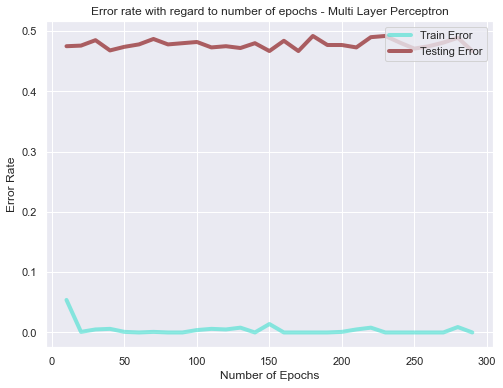

In [55]:
import seaborn as sns
sns.set()

plt.figure(figsize=(8, 6))
plt.title("Error rate with regard to number of epochs - Multi Layer Perceptron")
plt.xlabel('Number of Epochs')
plt.ylabel('Error Rate')
plt.plot(all_epochs, all_training_errors, alpha=0.6, linewidth=4, color='turquoise', label='Train Error')
plt.plot(all_epochs, all_testing_errors, alpha=0.6, linewidth=4, color='maroon', label = 'Testing Error')
plt.legend(loc='upper right')
plt.show()